In [1]:
!pip install diffusers==0.21.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.21.2-py3-none-any.whl size=1489252 sha256=dba943f93b5238a36106c829a88022358975f1f8bdde2b4d6d8659e3e5717124
  Stored in directory: /root/.cache/pip/wheels/2e/09/32/11c9e42c397d3f3494226b28ba68c4ad4718a68a65dba14ea6
Successfully built diffusers


In [2]:
import torch
from diffusers import StableDiffusionPipeline
# from .free_lunch_utils import register_free_upblock2d, register_free_crossattn_upblock2d

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

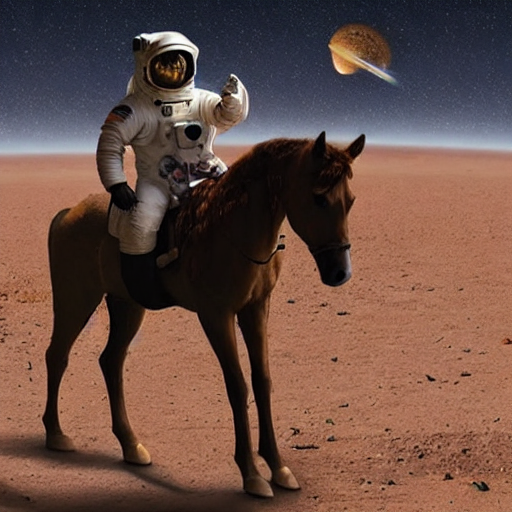

In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]
image

In [21]:
from typing import Any, Dict, Optional, Tuple

import torch
import torch.fft as fft



def isinstance_str(x: object, cls_name: str):
    for _cls in x.__class__.__mro__:
        if _cls.__name__ == cls_name:
            return True
    return False


def Fourier_filter(x_in, threshold, scale):

    x = x_in
    B, C, H, W = x.shape

    if (W & (W - 1)) != 0 or (H & (H - 1)) != 0:
        x = x.to(dtype=torch.float32)
    else:
        x = x

    x_freq = torch.fft.fftn(x, dim=(-2, -1))
    x_freq = torch.fft.fftshift(x_freq, dim=(-2, -1))

    B, C, H, W = x_freq.shape

    mask = torch.ones((B, C, H, W), device=x.device)

    crow, ccol = H // 2, W // 2

    for b in range(B):
        for c in range(C):
            for i in range(crow - threshold, crow + threshold):
                for j in range(ccol - threshold, ccol + threshold):
                    mask[b, c, i, j] = scale

    x_freq = x_freq * mask

    x_freq = torch.fft.ifftshift(x_freq, dim=(-2, -1))
    x_filtered = torch.fft.ifftn(x_freq, dim=(-2, -1)).real

    return x_filtered.to(dtype=x_in.dtype)


def register_free_upblock(model, b1=1.2, b2=1.4, s1=0.9, s2=0.2):
    """
    Register UpBlock2D with FreeU for UNet2DCondition.
    """

    def up_forward(self):
        def forward(
            hidden_states,
            res_hidden_states_tuple,
            temb=None,
            upsample_size=None,
            scale: float = 1.0
        ):

            for resnet in self.resnets:
                # pop res hidden states
                res_hidden_states = res_hidden_states_tuple[-1]
                res_hidden_states_tuple = res_hidden_states_tuple[:-1]

                # print(hidden_states.shape)
                # --------------- FreeU implement -----------------------
                if hidden_states.shape[1] == 1280:
                    hidden_states[:,:640] = hidden_states[:,:640] * self.b1
                    res_hidden_states = Fourier_filter(res_hidden_states, threshold=1, scale=self.s1)
                if hidden_states.shape[1] == 640:
                    hidden_states[:,:320] = hidden_states[:,:320] * self.b2
                    res_hidden_states = Fourier_filter(res_hidden_states, threshold=1, scale=self.s2)
                # ---------------------------------------------------------

                hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

                hidden_states = resnet(hidden_states, temb, scale=scale)

            if self.upsamplers is not None:
                for upsampler in self.upsamplers:
                    hidden_states = upsampler(hidden_states, upsample_size, scale=scale)

            return hidden_states

        return forward

    for i, upsample_block in enumerate(model.unet.up_blocks):
        if isinstance_str(upsample_block, "UpBlock2D"):
            upsample_block.forward = up_forward(upsample_block)
            upsample_block.b1 = b1
            upsample_block.b2 = b2
            upsample_block.s1 = s1
            upsample_block.s2 = s2




def register_free_crossattn_upblock(model, b1=1.2, b2=1.4, s1=0.9, s2=0.2):
    """
    Register CrossAttn UpBlock2D with FreeU for UNet2DCondition.
    """

    def up_forward(self):
        def forward(
            hidden_states, res_hidden_states_tuple, temb = None, encoder_hidden_states = None, cross_attention_kwargs = None,
            upsample_size = None, attention_mask = None, encoder_attention_mask = None,
        ):
            lora_scale = cross_attention_kwargs.get("scale", 1.0) if cross_attention_kwargs is not None else 1.0

            for resnet, attn in zip(self.resnets, self.attentions):
                # pop res hidden states
                res_hidden_states = res_hidden_states_tuple[-1]
                res_hidden_states_tuple = res_hidden_states_tuple[:-1]

                # --------------- FreeU implement -----------------------
                if hidden_states.shape[1] == 1280:
                    hidden_states[:,:640] = hidden_states[:,:640] * self.b1
                    res_hidden_states = Fourier_filter(res_hidden_states, threshold=1, scale=self.s1)
                if hidden_states.shape[1] == 640:
                    hidden_states[:,:320] = hidden_states[:,:320] * self.b2
                    res_hidden_states = Fourier_filter(res_hidden_states, threshold=1, scale=self.s2)
                # ---------------------------------------------------------

                hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

                hidden_states = resnet(hidden_states, temb, scale=lora_scale)
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                    return_dict=False,
                )[0]

            if self.upsamplers is not None:
                for upsampler in self.upsamplers:
                    hidden_states = upsampler(hidden_states, upsample_size, scale=lora_scale)

            return hidden_states

        return forward

    for i, upsample_block in enumerate(model.unet.up_blocks):
        if isinstance_str(upsample_block, "CrossAttnUpBlock2D"):
            upsample_block.forward = up_forward(upsample_block)
            upsample_block.b1 = b1
            upsample_block.b2 = b2
            upsample_block.s1 = s1
            upsample_block.s2 = s2


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

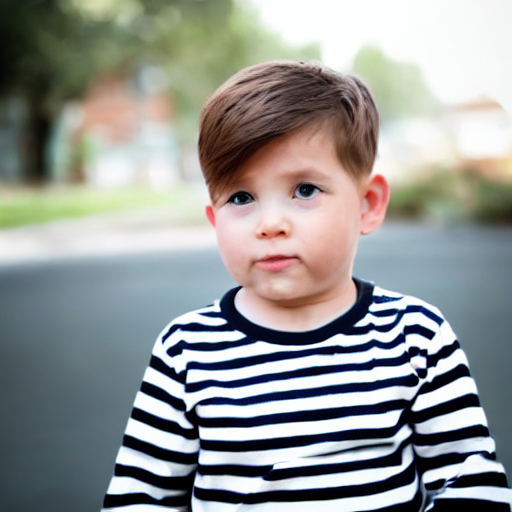

In [26]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
model = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
model = model.to("cuda")

prompt = "a photo of an cute boy"
image = model(prompt).images[0]
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

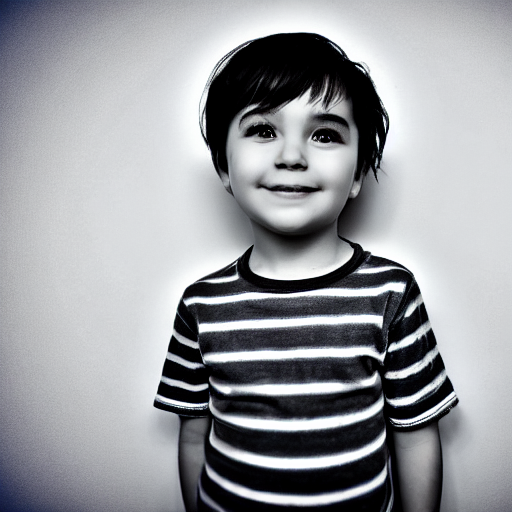

In [29]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
model_freeu = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
model_freeu = model_freeu.to("cuda")


register_free_upblock(model_freeu, b1=1.2, b2=1.4, s1=0.9, s2=0.2)
register_free_crossattn_upblock(model_freeu, b1=1.2, b2=1.4, s1=0.9, s2=0.2)


prompt = "a photo of an cute boy"
image_freeu = model_freeu(prompt).images[0]
image_freeu

In [ ]:
{import torch
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
model_freeu = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
model_freeu = model_freeu.to("cuda")


register_free_upblock(model_freeu, b1=1.2, b2=1.4, s1=0.9, s2=0.2)
register_free_crossattn_upblock(model_freeu, b1=1.2, b2=1.4, s1=0.9, s2=0.2)


prompt = "a photo of an cute boy"
image_freeu = model_freeu(prompt).images[0]